# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa18.github.io/assignments2018/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [22]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs682/classifiers/softmax.py**. 


In [23]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

TypeError: 'numpy.float64' object is not callable

## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:**Because the weight matrix is set randomly at first, and the probability of each correct predicted class is 1/10 = 0.1. And the final loss is about -log(0.1).**


In [25]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.430969 analytic: 0.430969, relative error: 1.225236e-07
numerical: -2.259859 analytic: -2.259859, relative error: 2.230694e-08
numerical: 0.887107 analytic: 0.887107, relative error: 1.077869e-08
numerical: -0.930786 analytic: -0.930786, relative error: 9.036088e-10
numerical: -0.652169 analytic: -0.652169, relative error: 8.868662e-08
numerical: -0.070281 analytic: -0.070281, relative error: 5.445137e-07
numerical: 0.456529 analytic: 0.456529, relative error: 1.332193e-07
numerical: -0.905030 analytic: -0.905030, relative error: 1.054326e-09
numerical: 0.554334 analytic: 0.554334, relative error: 2.627302e-10
numerical: -0.557211 analytic: -0.557211, relative error: 7.885134e-08
numerical: 1.128726 analytic: 1.128726, relative error: 2.172033e-08
numerical: 0.862678 analytic: 0.862678, relative error: 2.642638e-08
numerical: -0.576580 analytic: -0.576580, relative error: 5.979611e-08
numerical: -1.432440 analytic: -1.432440, relative error: 3.949055e-08
numerical: 4.01770

In [55]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.346547e+00 computed in 0.087499s
vectorized loss: 2.346547e+00 computed in 0.002715s
Loss difference: 0.000000
Gradient difference: 0.000000


In [58]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 7.5e-8, 1e-7, 2e-7, 3e-7, 5e-7, 7.5e-7]
regularization_strengths = [2e4, 2.5e4, 3e4, 3.5e4, 4e4, 4.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate, regularization_strength,
                              num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        acu_train = np.mean(y_train == y_train_pred)
        acu_val = np.mean(y_val == y_val_pred)
        results[(learning_rate, regularization_strength)] = (acu_train, acu_val)
        if acu_val > best_val:
            best_val = acu_val
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 620.432758
iteration 100 / 1500: loss 572.548216
iteration 200 / 1500: loss 528.601533
iteration 300 / 1500: loss 487.758129
iteration 400 / 1500: loss 450.108212
iteration 500 / 1500: loss 415.304374
iteration 600 / 1500: loss 383.557625
iteration 700 / 1500: loss 353.675167
iteration 800 / 1500: loss 326.645000
iteration 900 / 1500: loss 301.494820
iteration 1000 / 1500: loss 278.513556
iteration 1100 / 1500: loss 257.028003
iteration 1200 / 1500: loss 237.436730
iteration 1300 / 1500: loss 219.307994
iteration 1400 / 1500: loss 202.379994
iteration 0 / 1500: loss 777.091647
iteration 100 / 1500: loss 702.376179
iteration 200 / 1500: loss 634.943635
iteration 300 / 1500: loss 574.882862
iteration 400 / 1500: loss 519.763810
iteration 500 / 1500: loss 470.148434
iteration 600 / 1500: loss 425.593898
iteration 700 / 1500: loss 384.702074
iteration 800 / 1500: loss 348.175785
iteration 900 / 1500: loss 314.916236
iteration 1000 / 1500: loss 285.123686
iteration 

iteration 600 / 1500: loss 147.773305
iteration 700 / 1500: loss 116.609430
iteration 800 / 1500: loss 92.136133
iteration 900 / 1500: loss 72.711880
iteration 1000 / 1500: loss 57.658661
iteration 1100 / 1500: loss 45.744650
iteration 1200 / 1500: loss 36.380950
iteration 1300 / 1500: loss 29.083295
iteration 1400 / 1500: loss 23.271889
iteration 0 / 1500: loss 766.054991
iteration 100 / 1500: loss 567.315852
iteration 200 / 1500: loss 420.075824
iteration 300 / 1500: loss 311.661280
iteration 400 / 1500: loss 231.073493
iteration 500 / 1500: loss 171.578359
iteration 600 / 1500: loss 127.436197
iteration 700 / 1500: loss 95.029917
iteration 800 / 1500: loss 70.800773
iteration 900 / 1500: loss 52.812324
iteration 1000 / 1500: loss 39.650030
iteration 1100 / 1500: loss 29.989215
iteration 1200 / 1500: loss 22.727955
iteration 1300 / 1500: loss 17.386284
iteration 1400 / 1500: loss 13.418126
iteration 0 / 1500: loss 919.362891
iteration 100 / 1500: loss 641.329754
iteration 200 / 1500:

iteration 100 / 1500: loss 467.217259
iteration 200 / 1500: loss 283.415945
iteration 300 / 1500: loss 172.429602
iteration 400 / 1500: loss 105.078294
iteration 500 / 1500: loss 64.549757
iteration 600 / 1500: loss 39.834034
iteration 700 / 1500: loss 24.927450
iteration 800 / 1500: loss 15.950150
iteration 900 / 1500: loss 10.473405
iteration 1000 / 1500: loss 7.189342
iteration 1100 / 1500: loss 5.151804
iteration 1200 / 1500: loss 3.958381
iteration 1300 / 1500: loss 3.180410
iteration 1400 / 1500: loss 2.789440
iteration 0 / 1500: loss 931.531820
iteration 100 / 1500: loss 510.393657
iteration 200 / 1500: loss 280.080382
iteration 300 / 1500: loss 154.283952
iteration 400 / 1500: loss 85.372108
iteration 500 / 1500: loss 47.706272
iteration 600 / 1500: loss 27.064062
iteration 700 / 1500: loss 15.765425
iteration 800 / 1500: loss 9.556780
iteration 900 / 1500: loss 6.166868
iteration 1000 / 1500: loss 4.345227
iteration 1100 / 1500: loss 3.353438
iteration 1200 / 1500: loss 2.7646

iteration 1400 / 1500: loss 2.035997
iteration 0 / 1500: loss 912.958122
iteration 100 / 1500: loss 274.468202
iteration 200 / 1500: loss 83.601760
iteration 300 / 1500: loss 26.442584
iteration 400 / 1500: loss 9.367775
iteration 500 / 1500: loss 4.325649
iteration 600 / 1500: loss 2.714277
iteration 700 / 1500: loss 2.305042
iteration 800 / 1500: loss 2.156408
iteration 900 / 1500: loss 2.203950
iteration 1000 / 1500: loss 2.147662
iteration 1100 / 1500: loss 2.133467
iteration 1200 / 1500: loss 2.106718
iteration 1300 / 1500: loss 2.095803
iteration 1400 / 1500: loss 2.111339
iteration 0 / 1500: loss 1092.854793
iteration 100 / 1500: loss 268.696036
iteration 200 / 1500: loss 67.268948
iteration 300 / 1500: loss 18.050565
iteration 400 / 1500: loss 6.025346
iteration 500 / 1500: loss 3.063006
iteration 600 / 1500: loss 2.339473
iteration 700 / 1500: loss 2.183121
iteration 800 / 1500: loss 2.160447
iteration 900 / 1500: loss 2.119133
iteration 1000 / 1500: loss 2.099715
iteration 11

iteration 1400 / 1500: loss 2.108840
iteration 0 / 1500: loss 1079.577082
iteration 100 / 1500: loss 17.460474
iteration 200 / 1500: loss 2.314370
iteration 300 / 1500: loss 2.087942
iteration 400 / 1500: loss 2.113187
iteration 500 / 1500: loss 2.087094
iteration 600 / 1500: loss 2.068506
iteration 700 / 1500: loss 2.110958
iteration 800 / 1500: loss 2.133010
iteration 900 / 1500: loss 2.066161
iteration 1000 / 1500: loss 2.189376
iteration 1100 / 1500: loss 2.104502
iteration 1200 / 1500: loss 2.109158
iteration 1300 / 1500: loss 2.101356
iteration 1400 / 1500: loss 2.144713
iteration 0 / 1500: loss 1221.660602
iteration 100 / 1500: loss 11.547715
iteration 200 / 1500: loss 2.266688
iteration 300 / 1500: loss 2.167701
iteration 400 / 1500: loss 2.125515
iteration 500 / 1500: loss 2.159854
iteration 600 / 1500: loss 2.144096
iteration 700 / 1500: loss 2.140549
iteration 800 / 1500: loss 2.109647
iteration 900 / 1500: loss 2.127701
iteration 1000 / 1500: loss 2.154411
iteration 1100 / 

iteration 0 / 1500: loss 1240.326349
iteration 100 / 1500: loss 2.148262
iteration 200 / 1500: loss 2.126032
iteration 300 / 1500: loss 2.152541
iteration 400 / 1500: loss 2.149330
iteration 500 / 1500: loss 2.199010
iteration 600 / 1500: loss 2.161012
iteration 700 / 1500: loss 2.076848
iteration 800 / 1500: loss 2.144829
iteration 900 / 1500: loss 2.136443
iteration 1000 / 1500: loss 2.160297
iteration 1100 / 1500: loss 2.127925
iteration 1200 / 1500: loss 2.143500
iteration 1300 / 1500: loss 2.056755
iteration 1400 / 1500: loss 2.080138
iteration 0 / 1500: loss 1388.570510
iteration 100 / 1500: loss 2.089176
iteration 200 / 1500: loss 2.148204
iteration 300 / 1500: loss 2.165208
iteration 400 / 1500: loss 2.115993
iteration 500 / 1500: loss 2.137456
iteration 600 / 1500: loss 2.170011
iteration 700 / 1500: loss 2.172733
iteration 800 / 1500: loss 2.139251
iteration 900 / 1500: loss 2.121739
iteration 1000 / 1500: loss 2.139666
iteration 1100 / 1500: loss 2.124640
iteration 1200 / 15

In [59]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.337000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:
True
*Your explanation*:
When the difference between the score of correct answer and the largest score of wrong answers is smaller than the margin, the loss of SVM won't change at all. But under no condition will the Softmax loss keep unchanged.

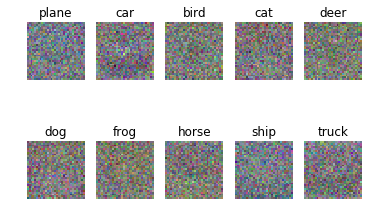

In [60]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])